In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import os
# os.environ['PATH'] += os.pathsep + 'D:\\6OHDA\\'
import numpy as np
import scipy as sci
from IO import *
from utils import *
import re
from tqdm import tqdm

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from tensorflow.keras.layers import Convolution2D, MaxPooling2D,Conv2D, Conv1D,MaxPooling1D
# from tensorflow.keras.layers.core import Lambda
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import pickle
import random
# import png

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.config.list_physical_devices()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11428835908527348022
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1166575265534243066
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7586745569872312156
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [6]:
# load MNIST data
# tf.keras.datasets.mnist.load_data(path="E:\\data\\mnist.npz")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [17]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
print(y_train[:6])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
[5 0 4 1 9 2]


In [109]:
# create generators to see if that is the issue:
def trainGen(x_train,y_train):
    while True:
        for ind in range(len(y_train)):
            if ind>5000:
                break
            yield (x_train[ind].reshape(-1, 28, 28, 1),np.array([(y_train[ind])]))
def validateGen(x_train,y_train):
    while True:
        for ind in range(5000,len(y_train)):
            yield (x_train[ind].reshape(-1, 28, 28, 1),np.array([(y_train[ind])]))

In [164]:
# create generators to see if that is the issue:
def trainGen(x_train,y_train, butchSize = 32):
    ind = 0;
    while True:
        butchlabels = []
        butchData = np.empty((butchSize,28, 28, 1))
        for d in range(butchSize):
            butchData[d,] = x_train[ind] 
            butchlabels.append(y_train[ind])
            if ind<len(y_train)-1:
                ind = ind+1
            else:
                ind=0
        yield (butchData,np.array(butchlabels))
def validateGen(x_train,y_train, butchSize = 32):
    ind = 0;
    while True:
        butchlabels = []
        butchData = np.empty((butchSize,28, 28, 1))
        for d in range(butchSize):
            butchData[d,] = x_train[ind] 
            butchlabels.append(y_train[ind])
            if ind<len(y_train)-1:
                ind = ind+1
            else:
                ind=0
        yield (butchData,np.array(butchlabels))


In [74]:
for ind,(label,dataP) in enumerate(trainGen(x_train,y_train)):
    print(label.shape,dataP.shape)
    if ind>5:
        break


(1, 28, 28, 1) (1,)
(1, 28, 28, 1) (1,)
(1, 28, 28, 1) (1,)
(1, 28, 28, 1) (1,)
(1, 28, 28, 1) (1,)
(1, 28, 28, 1) (1,)
(1, 28, 28, 1) (1,)


[5] 5 (28, 28, 1)
[0] 0 (28, 28, 1)
[4] 4 (28, 28, 1)


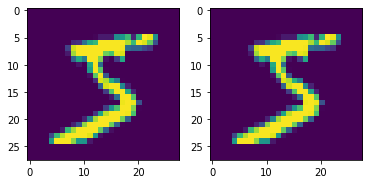

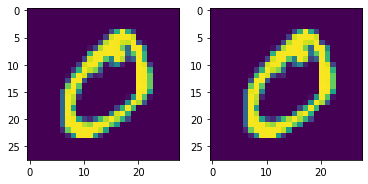

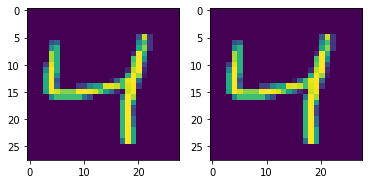

In [158]:
ind = 0
for (g_x,g_y),x,y in zip(trainGen(x_train,y_train,1),x_train,y_train):
    print(g_y,y,x.shape)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(g_x[0,:,:,:])
    ax[1].imshow(x)
    ind = ind+1
    if ind>2:
        break
    


In [165]:
del model
initializer = tf.keras.initializers.Ones()
model = Sequential()
model.add(Conv2D(16, kernel_size=(10,10), activation='relu', input_shape=(28,28,1),kernel_initializer=initializer))
model.add(Conv2D(32, kernel_size=(5,5), activation='relu',kernel_initializer=initializer))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_initializer=initializer))
model.add(Flatten())
model.add(Dense(50, activation='relu',kernel_initializer=initializer))
model.add(Dense(10, activation='softmax'))

In [166]:
del model2
initializer = tf.keras.initializers.Ones()
model2 = Sequential()
model2.add(Conv2D(16, kernel_size=(10,10), activation='relu', input_shape=(28,28,1),kernel_initializer=initializer))
model2.add(Conv2D(32, kernel_size=(5,5), activation='relu',kernel_initializer=initializer))
model2.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_initializer=initializer))
model2.add(Flatten())
model2.add(Dense(50, activation='relu',kernel_initializer=initializer))
model2.add(Dense(10, activation='softmax'))

In [134]:
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 19, 19, 16)        1616      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 15, 15, 32)        12832     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
flatten_15 (Flatten)         (None, 10816)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 50)                540850    
_________________________________________________________________
dense_31 (Dense)             (None, 10)                510       
Total params: 574,304
Trainable params: 574,304
Non-trainable params: 0
_______________________________________________

In [167]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(trainGen(x_train[:5000],y_train[:5000]),validation_data =validateGen(x_train[5000:],y_train[5000:]) ,
                    batch_size = 32,epochs=20,steps_per_epoch=30,validation_steps=20)

history2 = model2.fit(x_train[:5000],y_train[:5000],validation_data=(x_train[5000:],y_train[5000:]), 
                    batch_size = 32,epochs=20,steps_per_epoch=30,validation_steps=20)

# print(dataP.shape)
# model.fit(loadData(data))


Epoch 1/20
30/30 [==============================] - 1s 10ms/step - loss: 43879030784.0000 - accuracy: 0.0906 - val_loss: 15957421056.0000 - val_accuracy: 0.1000
Epoch 2/20
30/30 [==============================] - 0s 6ms/step - loss: 6919161856.0000 - accuracy: 0.0969 - val_loss: 1992315520.0000 - val_accuracy: 0.0953
Epoch 3/20
30/30 [==============================] - 0s 6ms/step - loss: 1353746816.0000 - accuracy: 0.1083 - val_loss: 655931008.0000 - val_accuracy: 0.0875
Epoch 4/20
30/30 [==============================] - 0s 6ms/step - loss: 713066816.0000 - accuracy: 0.1260 - val_loss: 733315200.0000 - val_accuracy: 0.1844
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 741206400.0000 - accuracy: 0.1198 - val_loss: 680553920.0000 - val_accuracy: 0.1719
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 511026048.0000 - accuracy: 0.1667 - val_loss: 469962496.0000 - val_accuracy: 0.1406
Epoch 7/20
30/30 [==============================] - 0s 6

In [284]:
## Saving the model
# model.save('E:\\caLFP_v1')
# model.save_weights("E:\\caOnly_v1_weights.h5")

INFO:tensorflow:Assets written to: E:\caOnly_v1\assets


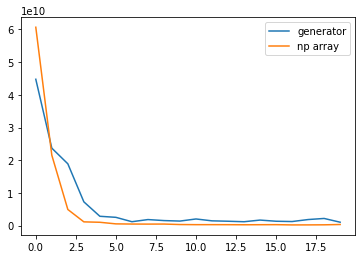

In [137]:
plt.plot(history.history['loss'],label='generator')
plt.plot(history2.history['loss'],label='np array')

# plt.plot(np.arange(1,20),history.history['val_loss'][1:],label='validate')
plt.legend()

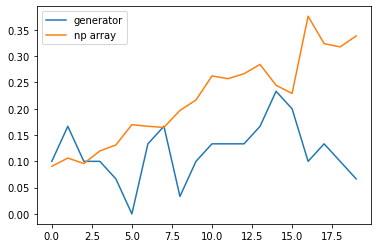

In [138]:
plt.plot(history.history['accuracy'],label='generator')
plt.plot(history2.history['accuracy'],label='np array')
# plt.plot(history.history['val_accuracy'],label='validate')
plt.legend()

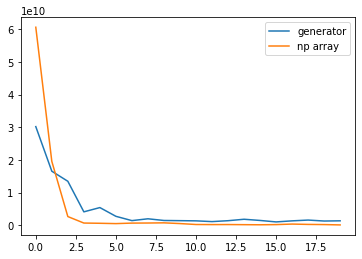

In [147]:
plt.plot(history.history['loss'],label='generator')
plt.plot(history2.history['loss'],label='np array')

# plt.plot(np.arange(1,20),history.history['val_loss'][1:],label='validate')
plt.legend()

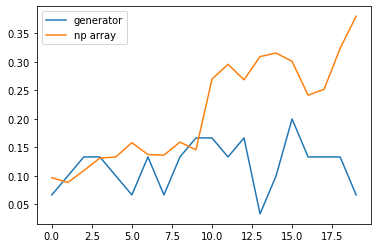

In [148]:
plt.plot(history.history['accuracy'],label='generator')
plt.plot(history2.history['accuracy'],label='np array')
# plt.plot(history.history['val_accuracy'],label='validate')
plt.legend()

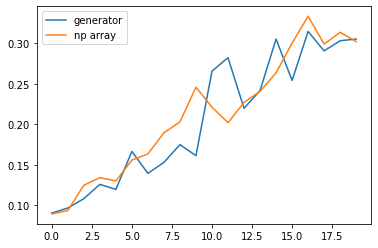

In [168]:
plt.plot(history.history['accuracy'],label='generator')
plt.plot(history2.history['accuracy'],label='np array')
# plt.plot(history.history['val_accuracy'],label='validate')
plt.legend()

In [29]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

labels = np.unique(y_train)
pred = model.predict(x_test,verbose=1)
pred = np.argmax(pred,axis=1)
y = y_test
# print(np.unique(pred))

# y = []
# for f in test_generator.filenames:
#     y.append( labels[f.split("_")[2]])

313/313 [==============================] - 0s 1ms/step


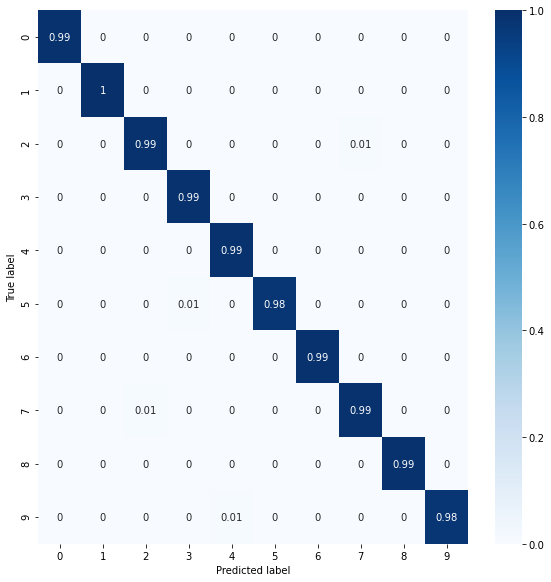

In [31]:
classes=np.arange(10)
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()